<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Variational-Autoencoder-Using-Keras-data-Dsprites" data-toc-modified-id="Variational-Autoencoder-Using-Keras-data-Dsprites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Variational Autoencoder Using Keras data Dsprites</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-dataset" data-toc-modified-id="Description-of-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Description of the dataset</a></span></li><li><span><a href="#Generating-the-Training-and-test-data" data-toc-modified-id="Generating-the-Training-and-test-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Generating the Training and test data</a></span></li></ul></li><li><span><a href="#Building-the-VAE" data-toc-modified-id="Building-the-VAE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Building the VAE</a></span><ul class="toc-item"><li><span><a href="#VAE-Summary" data-toc-modified-id="VAE-Summary-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>VAE Summary</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Reconstruction" data-toc-modified-id="Reconstruction-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Reconstruction</a></span></li></ul></li><li><span><a href="#Sampling-from-the-Latent-Space" data-toc-modified-id="Sampling-from-the-Latent-Space-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Sampling from the Latent Space</a></span></li></ul></li></ul></div>

# Variational Autoencoder Using Keras data Dsprites

The code is based on the book [Generative Deep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/).


## Data

The data is taken from [Dsprites dataset](https://github.com/deepmind/dsprites-dataset). 

For loading the dataset we used this [notebook](https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb).

The datafiles are on the input folder.

In [53]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [6]:
path = os.getcwd()
dataset_zip = np.load(path+'/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                     ,encoding='bytes', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]


print('Metadata: \n', metadata)

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f4df3d61ac8>)
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22

### Description of the dataset

From the metadata we have the description of the dataset and how it was generated:

    'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.'

The latent space size for generating the dataset is:

    - 'latents_sizes': array([ 1,  3,  6, 40, 32, 32]), 

Each latent affect only one attribute of the figure, the atributes are:

    - 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
    
**Therefore, we have only one color, 3 shapes, 6 types of scales, 40 points regarding rotations, 32 points for the posX (or posY).**

In [17]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']

In [18]:
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

Generating helper functions to handle the data

In [19]:
def latent_to_index(latents):    
    return np.dot(latents, latents_bases).astype(int)

In [20]:
def ytest_to_index(latents):
    """Creating ytest index for posX feature.
    
    Parameters:
    -----------------------------------------
    latents(list): Latents.
    
    """
    return np.dot(latents,[0,0,0,0,1,0]).astype(int)#<--------<<<<< to use as an index for the scatterplot (posX ??)

In [21]:
def sample_latent(size=1):
    """Sample the latent space.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

### Generating the Training and test data

Here we generate the dataset randomly.

In [22]:
# Sample latents randomly <-----------------------<<<<< modified for use with Dsprites
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)

#To use as an index for the scatterplot (posX)
y_test = ytest_to_index(latents_sampled)

# imgs_sampled = imgs[indices_sampled]
x_test = imgs[indices_sampled]
x_test = x_test.reshape(x_test.shape + (1,))

In [30]:
# Sample latents randomly
latents_sampled_train = sample_latent(size=30000)

# Select images
indices_sampled_train = latent_to_index(latents_sampled_train)
imgs_sampled = imgs[indices_sampled]

x_train = imgs[indices_sampled_train]
x_train = x_train.reshape(x_train.shape + (1,))

In [29]:
print('Analysing the shapes:\n'+ 
      ' X train shape: {} \n Y test shape: {} \n X test shape: {} \n'.format(x_train.shape,
                                                                               y_test.shape,
                                                                               x_test.shape))

Analysing the shapes:
 X train shape: (30000, 64, 64, 1) 
 Y test shape: (5000,) 
 X test shape: (5000, 64, 64, 1) 



## Building the VAE

*In this notebook I will ignore Furure and Deprecation Warnings*

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning) 

In [43]:
from Models.VAE_Keras import VariationalAutoencoder_Keras

**Choose 'build' if you want to train the VAE, if you want to reload weights type 'reconstruct'.**

In [4]:
# run params

SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'Dsprites'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode = 'reconstruct'

In [47]:
#Latent size
z_latent = 8

vae = VariationalAutoencoder_Keras(
    input_dim = (64,64,1) 
    , encoder_conv_filters = [32,64,64]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,2]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = z_latent
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

### VAE Summary

In [22]:
vae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [23]:
vae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             147456    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
__________

## Training

In [27]:
#Compile Parameters

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000 
BETA = 1

In [28]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

W0212 13:18:38.683874 140129284990784 deprecation_wrapper.py:119] From /home/nahum/anaconda3/envs/generative/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [29]:
# Training Parameters

BATCH_SIZE = 256

EPOCHS = 20

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [30]:
vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
        )

W0212 13:18:50.749773 140129284990784 deprecation_wrapper.py:119] From /home/nahum/anaconda3/envs/generative/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/20
30000/30000 [==============================] - 467s 16ms/step - loss: 46.7046 - vae_r_loss: 41.0975 - vae_kl_loss: 5.6070

Epoch 00001: saving model to run/vae/0001_Dsprites/weights/weights-001-46.70.h5

Epoch 00001: saving model to run/vae/0001_Dsprites/weights/weights.h5
Epoch 2/20
30000/30000 [==============================] - 461s 15ms/step - loss: 19.4671 - vae_r_loss: 12.2429 - vae_kl_loss: 7.2242

Epoch 00002: saving model to run/vae/0001_Dsprites/weights/weights-002-19.47.h5

Epoch 00002: saving model to run/vae/0001_Dsprites/weights/weights.h5
Epoch 3/20
30000/30000 [==============================] - 462s 15ms/step - loss: 18.5309 - vae_r_loss: 11.3641 - vae_kl_loss: 7.1669

Epoch 00003: saving model to run/vae/0001_Dsprites/weights/weights-003-18.53.h5

Epoch 00003: saving model to run/vae/0001_Dsprites/weights/weights.h5
Epoch 4/20
30000/30000 [==============================] - 465s 16ms/step - loss: 18.0747 - vae_r_loss: 10.9528 - vae_kl_loss: 7.1219

Epoch 00004

## Analysis

### Reconstruction

Firstly let's check if the VAE can succefully reconstruct images.

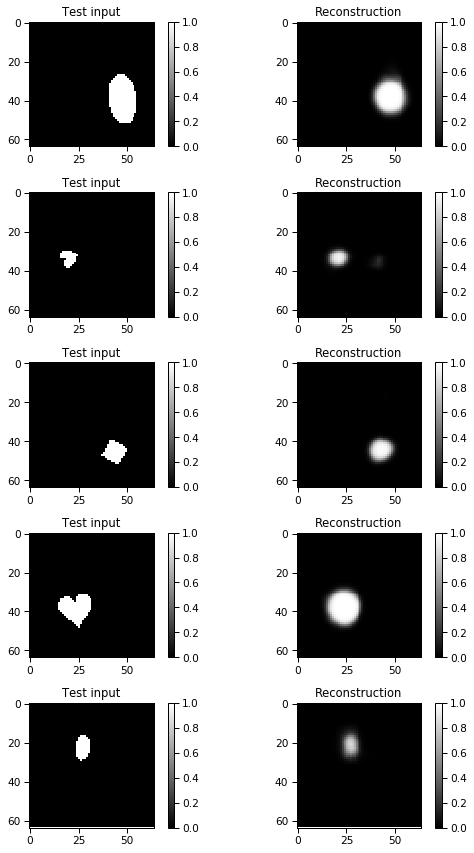

In [54]:
n_to_show = 5
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)    
    plt.imshow(example_images[i].reshape(64, 64), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(64, 64), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

## Sampling from the Latent Space

Here we want to sample the latent space randomly in order to see if the VAE can generate images. 

Let's sample coordinates 1 and 2 on the latent space randomly.

In [49]:
print("Size of the latent space: {}".format(z_latent))

Size of the latent space: 8


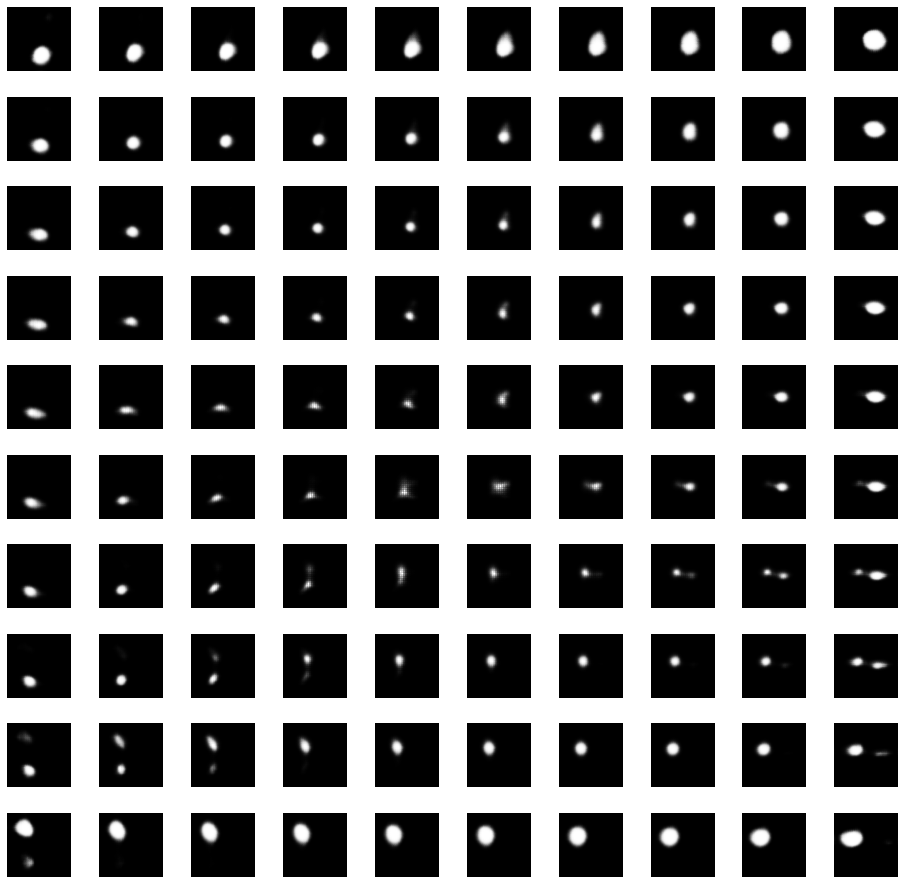

In [79]:
from scipy.stats import norm

grid_size=10
figsize=16

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))

xv, yv = np.meshgrid(x, y)

xv = xv.flatten() #<--------------------------<<<<< latent 1
yv = yv.flatten() #<--------------------------<<<<< latent 2

yvv = 0*yv
xvv = 0*xv

z_grid = np.array(list(zip(xv, yv))) #<-------<<<<< 0 for the second latent

samples = grid_size**2

bb = np.zeros((samples,z_latent))

for j in range(0,samples):
    bb[j] = np.append(z_grid[j],[0.,0.,0.,0.,0.,0.])#<-----<<< append other latent space fixed values (put by hand)

    
reconst = vae.decoder.predict(bb) #<-----------<<<<<< use bb(8 dim) instead of z_grid(2 dim)

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'gray')

Let's sample coordinates 2 and 3 on the latent space randomly.

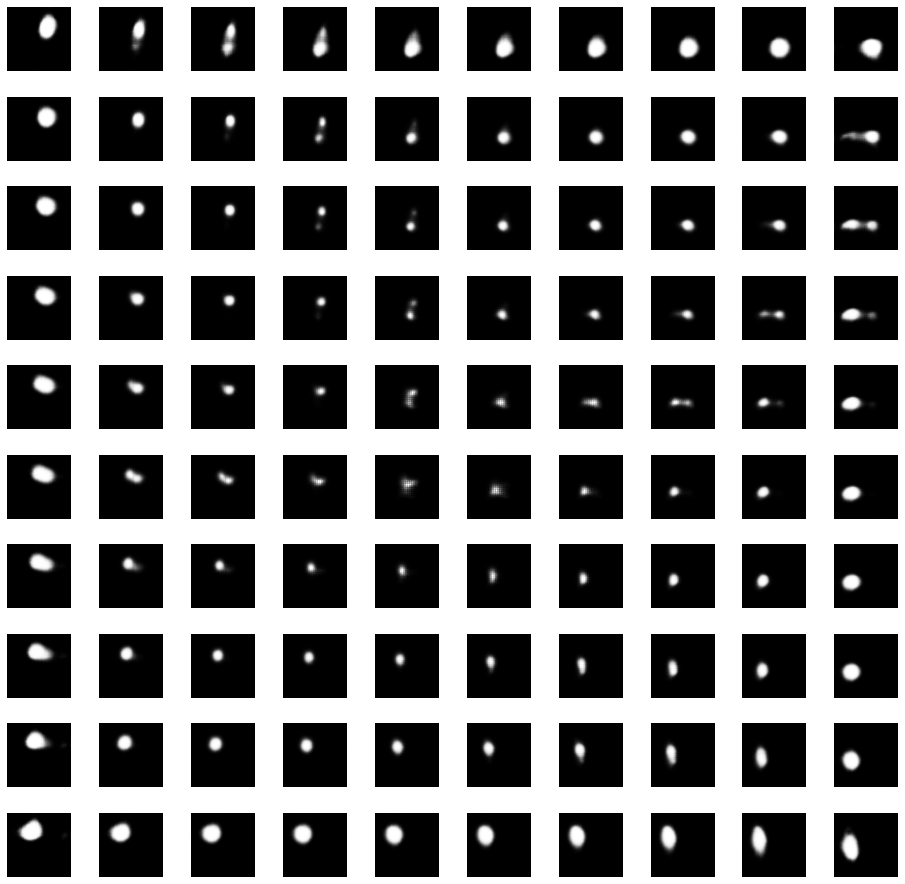

In [80]:
grid_size=10
figsize=16

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))

xv, yv = np.meshgrid(x, y)

xv = xv.flatten() #<--------------------------<<<<< latent 1
yv = yv.flatten() #<--------------------------<<<<< latent 2

xvv = 0.*xv

z_grid = np.array(list(zip(xvv, yv))) #<-------<<<<< 0 for the second latent

samples = grid_size**2

bb = np.zeros((samples,z_latent))

for j in range(0,samples):
    bb[j] = np.append(z_grid[j],[xv[j],0.,0.,0.,0.,0.])#<-----<<< append other latent space fixed values (put by hand)

    
reconst = vae.decoder.predict(bb) #<-----------<<<<<< use bb(8 dim) instead of z_grid(2 dim)

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'gray')

**We can do this for each combination of 2 coordinates on the latent space, since it is not easy to draw an 8D image, this is all that we can do in order to see if each coordinate corresponds to a feature.**

**From these examples we can see that two coordinates aren't encoding different properties of the image. The disentanglement of properties can be done usin an Beta-VAE.**